This notebook will do a 1day forecast and compare to persistence

Two types of forecast are:
1. Persistence: copy value from today to tomorrow
2. ML applied to features (INCLUDING the emissions from today) to predict the value for tomorrow

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
np.set_printoptions(threshold=10000)
import pandas as pd
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import seaborn as sns

In [2]:
fires = pd.read_csv('training_data_1day_forecast_day0poly.csv')
#split date into year/month/day feature
date = fires['Current Day'].values
years = [int(date[i][0:4]) for i in range(len(date))]
months = [int(date[i][5:7]) for i in range(len(date))]
days = [int(date[i][8:10]) for i in range(len(date))]
fires['years'] = years
fires['months'] = months
fires['days'] = days
print(fires.columns)

#get rid of rows which contain nans/zeros for LABELS
inds_features = np.where((fires['biomass_12Z_today']==0)|(fires['biomass_12Z_tomorrow']==0))

fires = fires.drop(labels=inds_features[0], axis=0)


Index(['Unnamed: 0', 'Incident Number', 'Fire Name', 'Current Day', 'Lat Fire',
       'Lon Fire', 'Number of VIIRS points', 'TLML_12Z_0', 'QLML_12Z_0',
       'SPEEDLML_12Z_0', 'PS_12Z_0', 'T_12Z_700mb_0', 'T_12Z_500mb_0',
       'QV_12Z_700mb_0', 'PBLH_12Z_0', 'TCZPBL_12Z_0', 'TLML_12Z_1',
       'QLML_12Z_1', 'SPEEDLML_12Z_1', 'PS_12Z_1', 'T_12Z_700mb_1',
       'T_12Z_500mb_1', 'QV_12Z_700mb_1', 'PBLH_12Z_1', 'TCZPBL_12Z_1', 'fccs',
       'slp', 'asp', 'precip_0', 'precip_1', 'ESATLML_12Z_0', 'ELML_12Z_0',
       'HDWLML_0', 'RHLML_12Z_0', 'ESATLML_12Z_1', 'ELML_12Z_1', 'HDWLML_1',
       'RHLML_12Z_1', 'Td_12Z_700mb_0', 'E_700mb_0', 'HAINES_0',
       'Td_12Z_700mb_1', 'E_700mb_1', 'HAINES_1', 'biomass_12Z_today',
       'biomass_12Z_tomorrow', 'years', 'months', 'days'],
      dtype='object')


## Split into features for the different forecasts, labels, and persistence forecast

1. feat_day0 = today's met, fuels, derived, emissions today
2. feat_day0and1 = today and tomorrow's met, fuels, derived, emissions today
3. feat_day0and1_indices= today and tomorrow's met INDICES, emissions today

In [3]:
feat_day0_emiss  = ['biomass_12Z_today']
feat_day0_emiss_static=['fccs','slp', 'asp', 'biomass_12Z_today']
feat_day0 = ['years', 'months', 'days','Lat Fire','Lon Fire', 'Number of VIIRS points', 'TLML_12Z_0', 
             'QLML_12Z_0','SPEEDLML_12Z_0', 'PS_12Z_0', 'T_12Z_700mb_0', 'T_12Z_500mb_0','QV_12Z_700mb_0', 
             'PBLH_12Z_0', 'TCZPBL_12Z_0',  'fccs','slp', 'asp', 'precip_0', 'ESATLML_12Z_0', 'ELML_12Z_0',
             'HDWLML_0', 'RHLML_12Z_0',  'Td_12Z_700mb_0', 'E_700mb_0', 'HAINES_0', 'biomass_12Z_today']
feat_day0and1= ['years', 'months', 'days', 'Lat Fire','Lon Fire', 'Number of VIIRS points', 'TLML_12Z_0', 
                'QLML_12Z_0','SPEEDLML_12Z_0', 'PS_12Z_0', 'T_12Z_700mb_0', 'T_12Z_500mb_0','QV_12Z_700mb_0', 
                'PBLH_12Z_0', 'TCZPBL_12Z_0', 'TLML_12Z_1','QLML_12Z_1', 'SPEEDLML_12Z_1', 'PS_12Z_1', 
                'T_12Z_700mb_1','T_12Z_500mb_1', 'QV_12Z_700mb_1', 'PBLH_12Z_1', 'TCZPBL_12Z_1', 'fccs','slp', 'asp', 
                'precip_0', 'precip_1', 'ESATLML_12Z_0', 'ELML_12Z_0','HDWLML_0', 'RHLML_12Z_0', 'ESATLML_12Z_1', 
                'ELML_12Z_1', 'HDWLML_1','RHLML_12Z_1', 'Td_12Z_700mb_0', 'E_700mb_0', 'HAINES_0','Td_12Z_700mb_1', 
                'E_700mb_1', 'HAINES_1', 'biomass_12Z_today']
feat_day0and1_indices = ['years', 'months', 'days', 'Lat Fire','Lon Fire', 'Number of VIIRS points','HDWLML_0',
                         'HDWLML_1', 'HAINES_0','HAINES_1', 'biomass_12Z_today']
labels_persistence = ['biomass_12Z_today']
labels = ['biomass_12Z_tomorrow']

In [4]:
features = fires.drop(labels=['biomass_12Z_tomorrow'], axis=1)
temp = np.log10(features.loc[:,'biomass_12Z_today'].values)
features.loc[:,'biomass_12Z_today'] = temp
print(features.columns) #features is a dataframe

labels = np.log10(fires.loc[:,'biomass_12Z_tomorrow'].values) #labels is a numpy array


Index(['Unnamed: 0', 'Incident Number', 'Fire Name', 'Current Day', 'Lat Fire',
       'Lon Fire', 'Number of VIIRS points', 'TLML_12Z_0', 'QLML_12Z_0',
       'SPEEDLML_12Z_0', 'PS_12Z_0', 'T_12Z_700mb_0', 'T_12Z_500mb_0',
       'QV_12Z_700mb_0', 'PBLH_12Z_0', 'TCZPBL_12Z_0', 'TLML_12Z_1',
       'QLML_12Z_1', 'SPEEDLML_12Z_1', 'PS_12Z_1', 'T_12Z_700mb_1',
       'T_12Z_500mb_1', 'QV_12Z_700mb_1', 'PBLH_12Z_1', 'TCZPBL_12Z_1', 'fccs',
       'slp', 'asp', 'precip_0', 'precip_1', 'ESATLML_12Z_0', 'ELML_12Z_0',
       'HDWLML_0', 'RHLML_12Z_0', 'ESATLML_12Z_1', 'ELML_12Z_1', 'HDWLML_1',
       'RHLML_12Z_1', 'Td_12Z_700mb_0', 'E_700mb_0', 'HAINES_0',
       'Td_12Z_700mb_1', 'E_700mb_1', 'HAINES_1', 'biomass_12Z_today', 'years',
       'months', 'days'],
      dtype='object')


## Do the train test split and get the feature sets for each experiment
1. day0
2. day0and1
3. day0and1_indices

In [5]:
# do the train test split
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3)
#print(x_train.columns)

#set up the persistence experiment
y_pred_persistence = x_test.loc[:,labels_persistence]
print(y_pred_persistence.columns)

#set up the day0_emiss experiment
x_train_day0_emiss=x_train.loc[:,feat_day0_emiss]
x_test_day0_emiss=x_test.loc[:,feat_day0_emiss]
print(x_train_day0_emiss.columns)

#set up the day0_emiss_static experiment
x_train_day0_emiss_static=x_train.loc[:,feat_day0_emiss_static]
x_test_day0_emiss_static=x_test.loc[:,feat_day0_emiss_static]
print(x_train_day0_emiss_static.columns)

#set up the day0 experiment
x_train_day0=x_train.loc[:,feat_day0]
x_test_day0=x_test.loc[:,feat_day0]
print(x_train_day0.columns)

#set up the day0and1 experiment
x_train_day0and1=x_train.loc[:,feat_day0and1]
x_test_day0and1=x_test.loc[:,feat_day0and1]
print(x_train_day0and1.columns)

#set up the day0and1_indices experiment
x_train_day0and1_indices=x_train.loc[:,feat_day0and1_indices]
x_test_day0and1_indices=x_test.loc[:,feat_day0and1_indices]
print(x_train_day0and1_indices.columns)

Index(['biomass_12Z_today'], dtype='object')
Index(['biomass_12Z_today'], dtype='object')
Index(['fccs', 'slp', 'asp', 'biomass_12Z_today'], dtype='object')
Index(['years', 'months', 'days', 'Lat Fire', 'Lon Fire',
       'Number of VIIRS points', 'TLML_12Z_0', 'QLML_12Z_0', 'SPEEDLML_12Z_0',
       'PS_12Z_0', 'T_12Z_700mb_0', 'T_12Z_500mb_0', 'QV_12Z_700mb_0',
       'PBLH_12Z_0', 'TCZPBL_12Z_0', 'fccs', 'slp', 'asp', 'precip_0',
       'ESATLML_12Z_0', 'ELML_12Z_0', 'HDWLML_0', 'RHLML_12Z_0',
       'Td_12Z_700mb_0', 'E_700mb_0', 'HAINES_0', 'biomass_12Z_today'],
      dtype='object')
Index(['years', 'months', 'days', 'Lat Fire', 'Lon Fire',
       'Number of VIIRS points', 'TLML_12Z_0', 'QLML_12Z_0', 'SPEEDLML_12Z_0',
       'PS_12Z_0', 'T_12Z_700mb_0', 'T_12Z_500mb_0', 'QV_12Z_700mb_0',
       'PBLH_12Z_0', 'TCZPBL_12Z_0', 'TLML_12Z_1', 'QLML_12Z_1',
       'SPEEDLML_12Z_1', 'PS_12Z_1', 'T_12Z_700mb_1', 'T_12Z_500mb_1',
       'QV_12Z_700mb_1', 'PBLH_12Z_1', 'TCZPBL_12Z_1', 'fccs'

## Train the models

### Linear Regression Models

1. lr_day0_emiss
2. lr_day0_emiss_static
3. lr_day0
4. lr_day0and1
5. lr_day0and1_indices

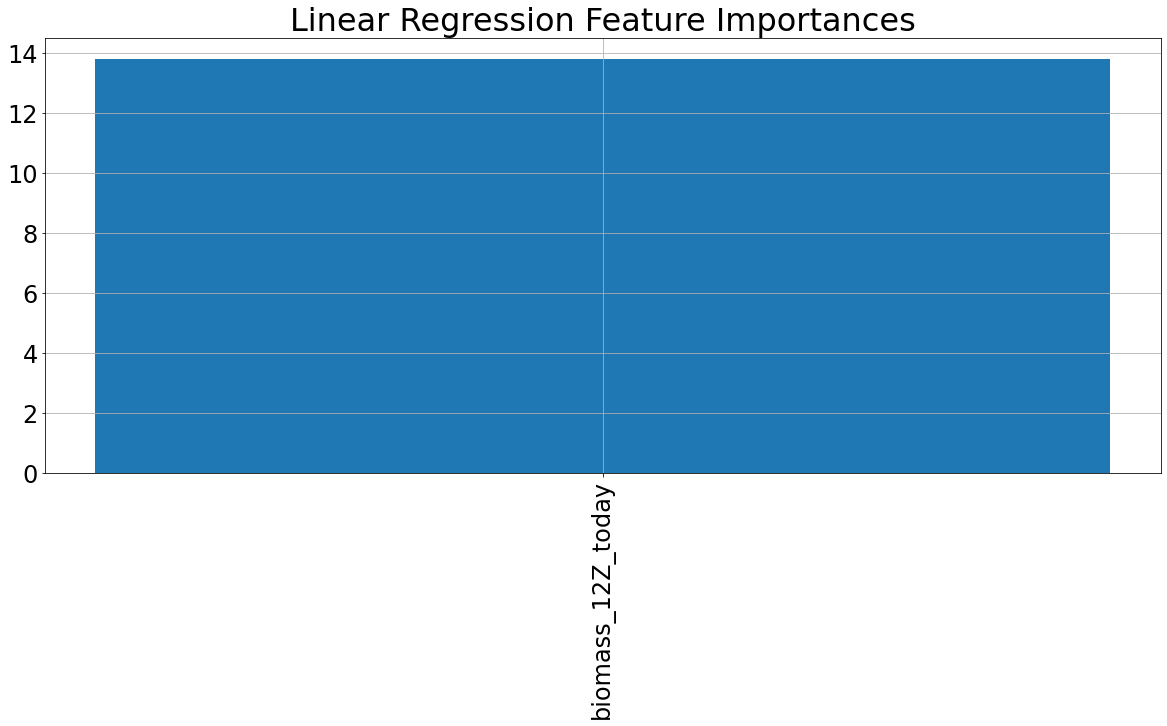

In [6]:
lr_day0_emiss = make_pipeline(StandardScaler(), LinearRegression()) #scaling is necessary
lr_day0_emiss.fit(x_train_day0_emiss, y_train)
y_lr_day0_emiss = lr_day0_emiss.predict(x_test_day0_emiss)

# perform permutation importance
results = permutation_importance(lr_day0_emiss, x_train_day0_emiss, y_train, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature:', feat_day0[i], ', Score: %.5f' % (v))
    
plt.figure(figsize=(20,8))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Linear Regression Feature Importances', fontsize=32)
plt.yticks(fontsize=24)
plt.xticks([i for i in range(len(importance))], labels = feat_day0_emiss, fontsize=24, rotation='vertical')
plt.grid(True)
plt.show()
#print(y_lr_day0.shape)

Feature: years , Score: 0.00051
Feature: months , Score: 0.00696
Feature: days , Score: 0.00001
Feature: Lat Fire , Score: 13.70724


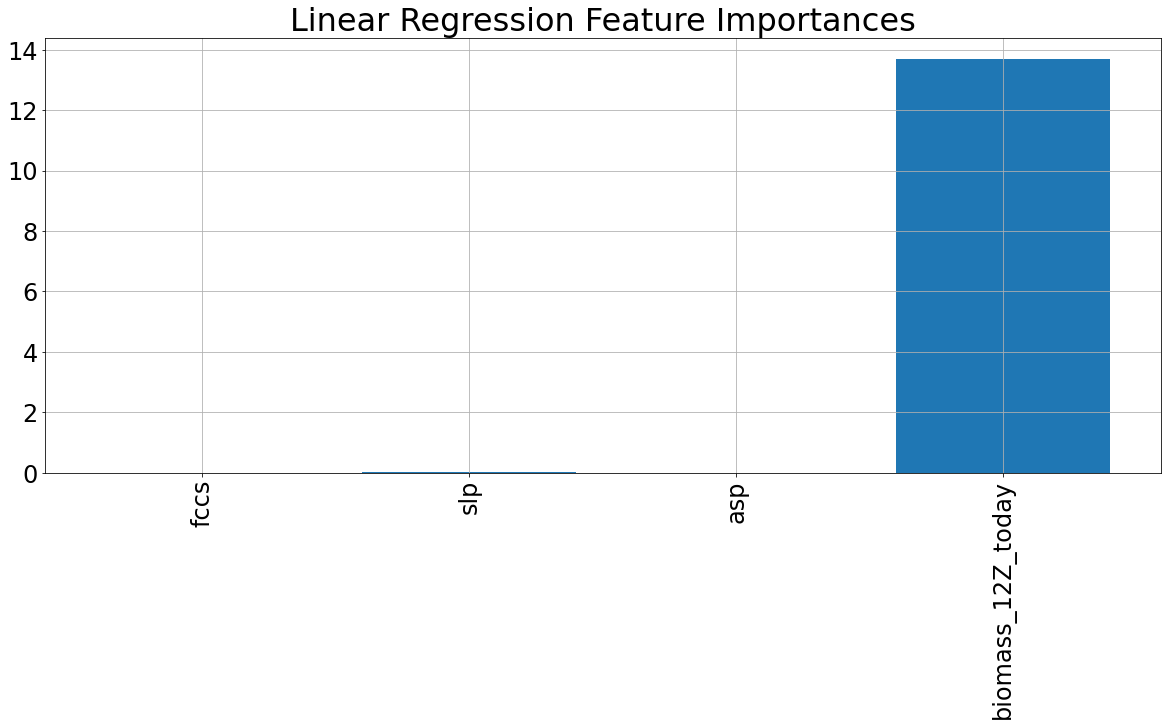

In [7]:
lr_day0_emiss_static = make_pipeline(StandardScaler(), LinearRegression()) #scaling is necessary
lr_day0_emiss_static.fit(x_train_day0_emiss_static, y_train)
y_lr_day0_emiss_static = lr_day0_emiss_static.predict(x_test_day0_emiss_static)

# perform permutation importance
results = permutation_importance(lr_day0_emiss_static, x_train_day0_emiss_static, y_train, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature:', feat_day0[i], ', Score: %.5f' % (v))
    
plt.figure(figsize=(20,8))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Linear Regression Feature Importances', fontsize=32)
plt.yticks(fontsize=24)
plt.xticks([i for i in range(len(importance))], labels = feat_day0_emiss_static, fontsize=24, rotation='vertical')
plt.grid(True)
plt.show()

#print(y_lr_day0.shape)

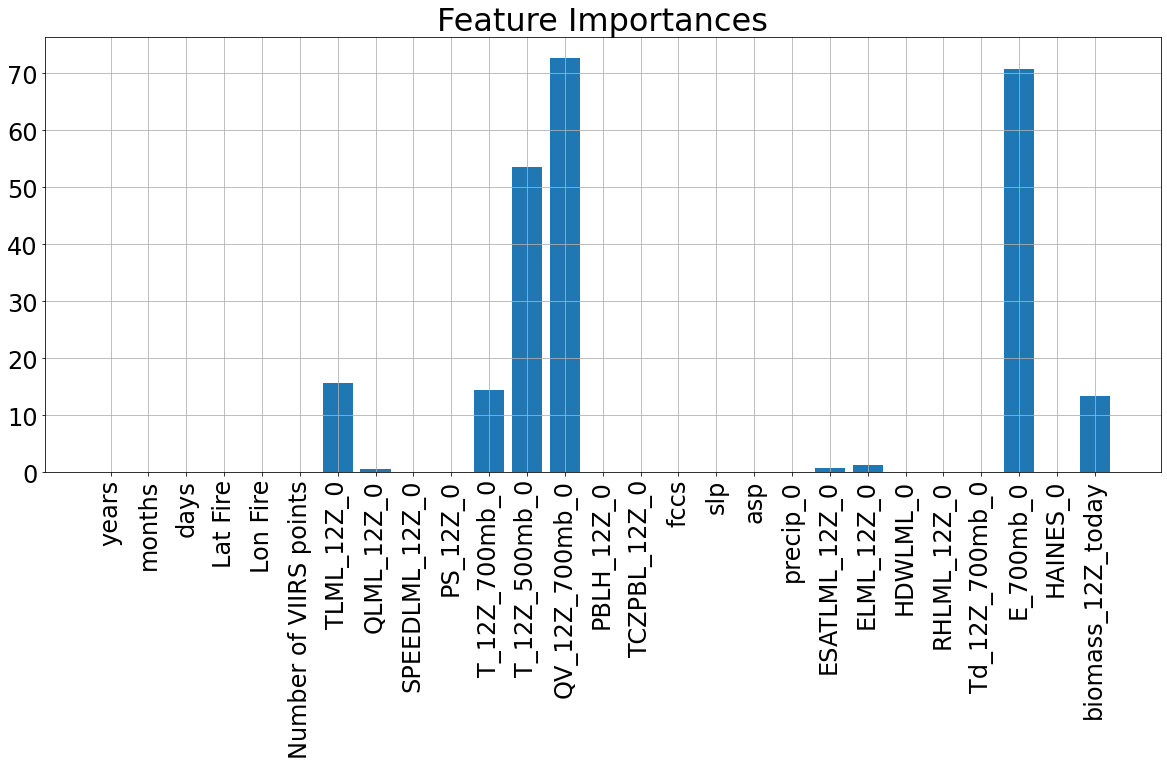

In [8]:
lr_day0 = make_pipeline(StandardScaler(), LinearRegression()) #scaling is necessary
lr_day0.fit(x_train_day0, y_train)
y_lr_day0 = lr_day0.predict(x_test_day0)

# perform permutation importance
results = permutation_importance(lr_day0, x_train_day0, y_train, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature:', feat_day0[i], ', Score: %.5f' % (v))
    
plt.figure(figsize=(20,8))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Feature Importances', fontsize=32)
plt.yticks(fontsize=24)
plt.xticks([i for i in range(len(importance))], labels = feat_day0, fontsize=24, rotation='vertical')
plt.grid(True)
plt.show()
#print(y_lr_day0.shape)

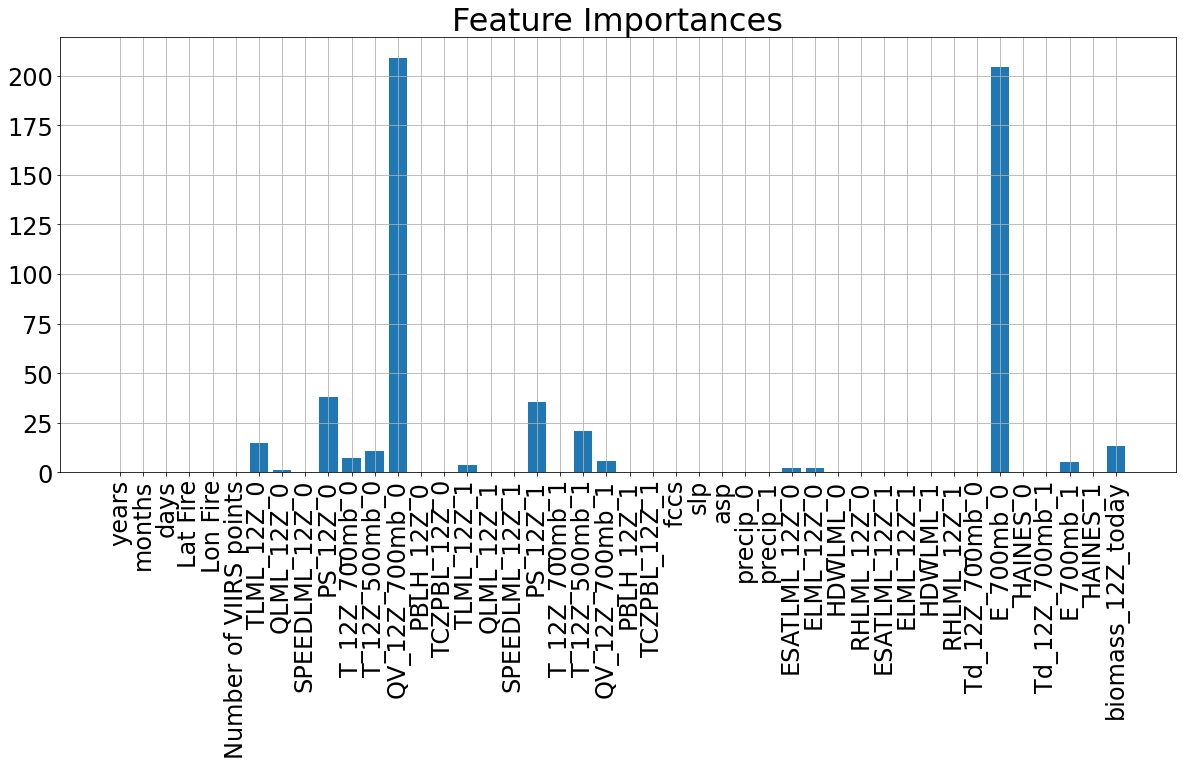

In [9]:
lr_day0and1 = make_pipeline(StandardScaler(), LinearRegression()) #scaling is necessary
lr_day0and1.fit(x_train_day0and1, y_train)
y_lr_day0and1 = lr_day0and1.predict(x_test_day0and1)

# perform permutation importance
results = permutation_importance(lr_day0and1, x_train_day0and1, y_train, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature:', feat_day0and1[i], ', Score: %.5f' % (v))
plt.figure(figsize=(20,8))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Feature Importances', fontsize=32)
plt.yticks(fontsize=24)
plt.xticks([i for i in range(len(importance))], labels = feat_day0and1, fontsize=24, rotation='vertical')
plt.grid(True)
plt.show()
#print(y_lr_day0and1.shape)

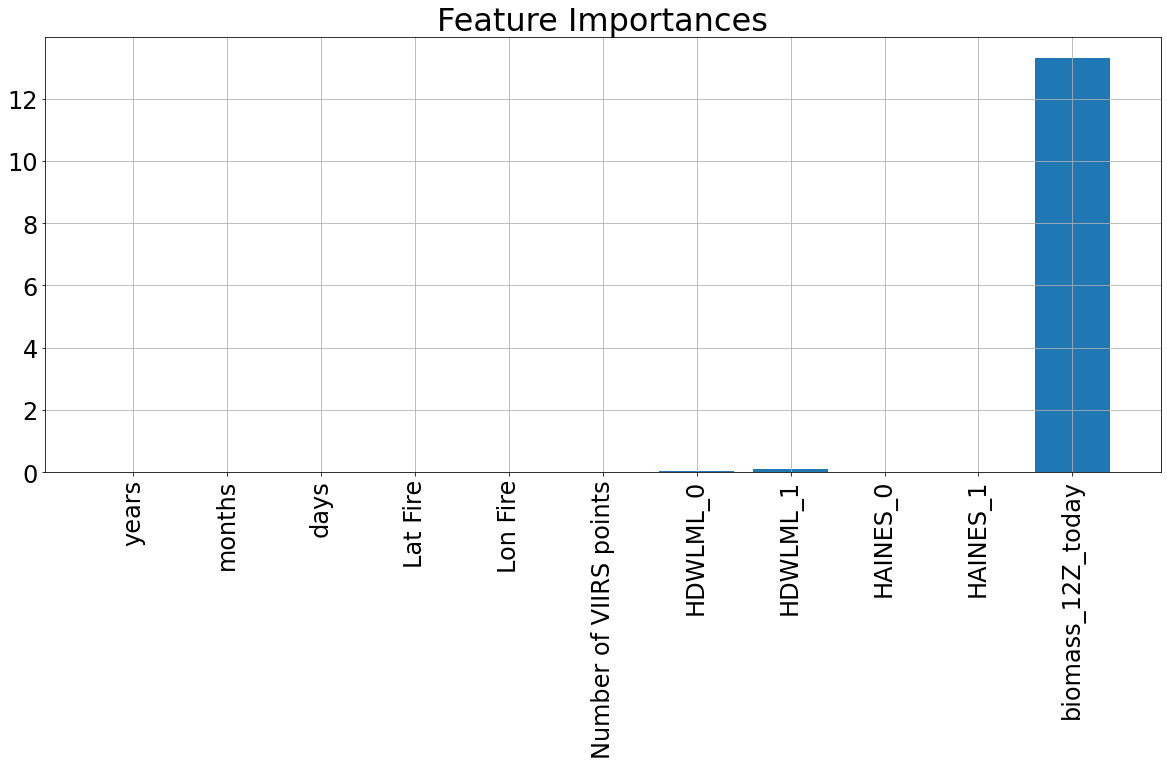

In [10]:
lr_day0and1_indices = make_pipeline(StandardScaler(), LinearRegression()) #scaling is necessary
lr_day0and1_indices.fit(x_train_day0and1_indices, y_train)
y_lr_day0and1_indices = lr_day0and1_indices.predict(x_test_day0and1_indices)

# perform permutation importance
results = permutation_importance(lr_day0and1_indices, x_train_day0and1_indices, y_train, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature:', feat_day0and1[i], ', Score: %.5f' % (v))
plt.figure(figsize=(20,8))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Feature Importances', fontsize=32)
plt.yticks(fontsize=24)
plt.xticks([i for i in range(len(importance))], labels = feat_day0and1_indices, fontsize=24, rotation='vertical')
plt.grid(True)
plt.show()
#print(y_lr_day0and1.shape)

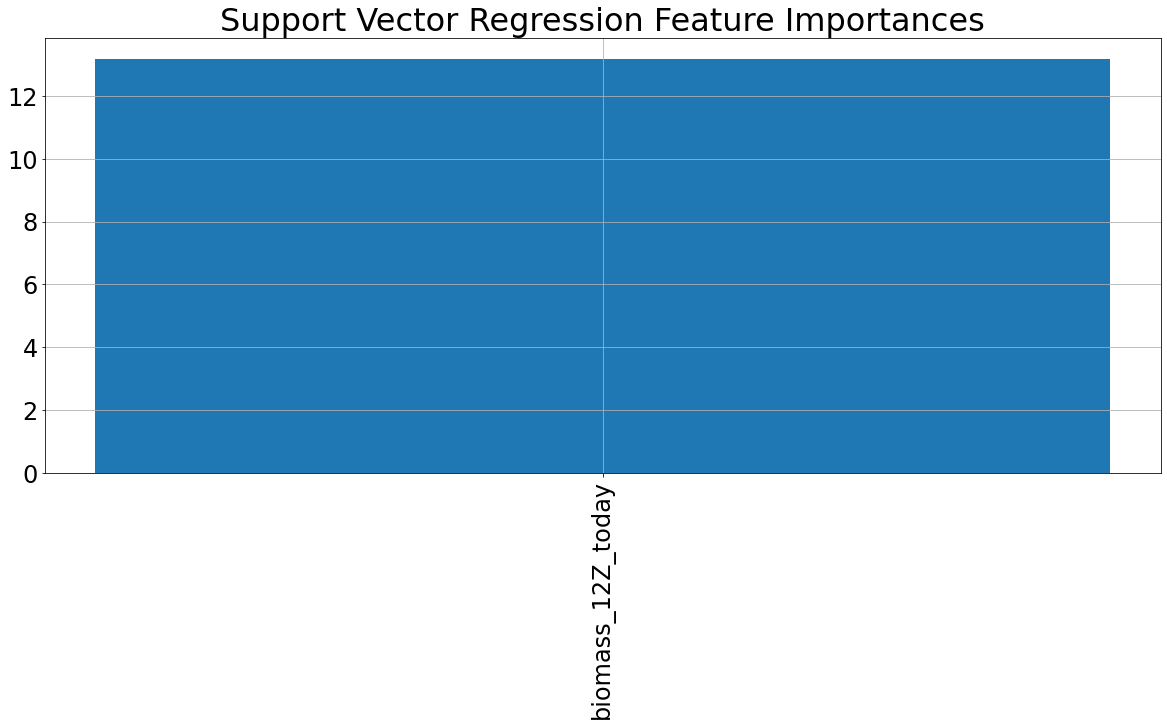

In [11]:
svr_day0_emiss = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2)) #scaling is necessary!
svr_day0_emiss.fit(x_train_day0_emiss, np.ravel(y_train))
y_svr_day0_emiss = svr_day0_emiss.predict(x_test_day0_emiss)
# perform permutation importance
results = permutation_importance(svr_day0_emiss, x_train_day0_emiss, y_train, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature:', feat_names[i], ', Score: %.5f' % (v))
plt.figure(figsize=(20,8))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Support Vector Regression Feature Importances', fontsize=32)
plt.yticks(fontsize=24)
plt.xticks([i for i in range(len(importance))], labels = feat_day0_emiss, fontsize=24, rotation='vertical')
plt.grid(True)
plt.show()

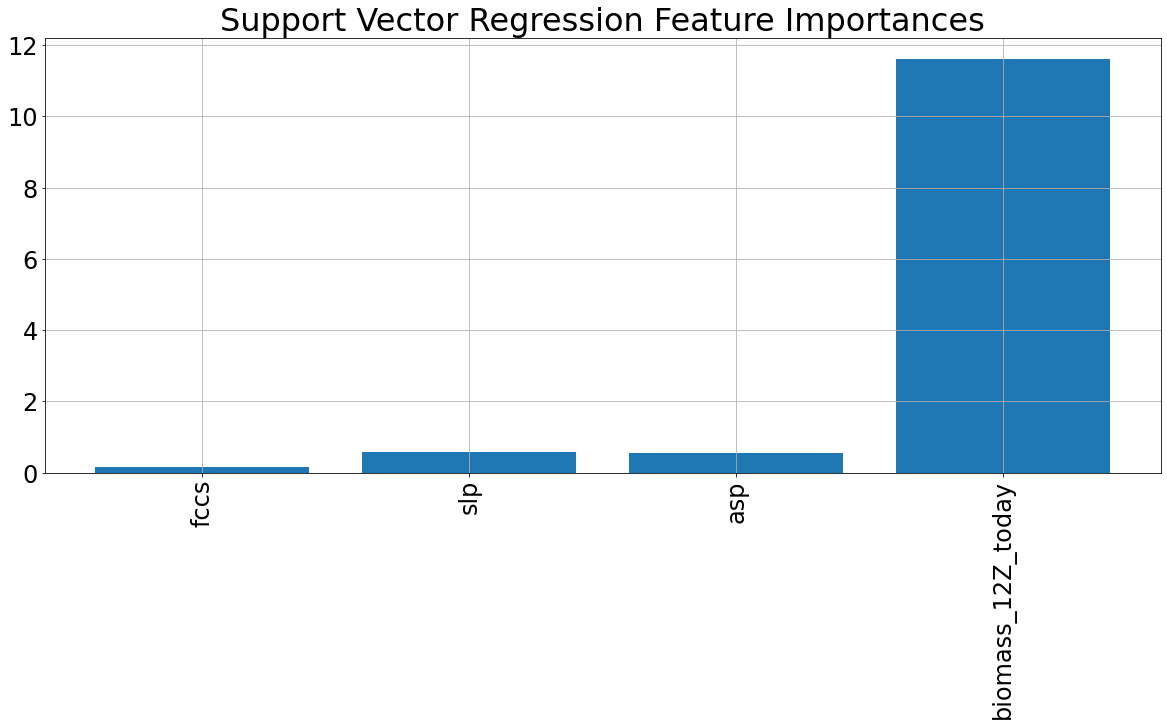

In [12]:
svr_day0_emiss_static = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2)) #scaling is necessary!
svr_day0_emiss_static.fit(x_train_day0_emiss_static, np.ravel(y_train))
y_svr_day0_emiss_static = svr_day0_emiss_static.predict(x_test_day0_emiss_static)
# perform permutation importance
results = permutation_importance(svr_day0_emiss_static, x_train_day0_emiss_static, y_train, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature:', feat_names[i], ', Score: %.5f' % (v))
plt.figure(figsize=(20,8))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Support Vector Regression Feature Importances', fontsize=32)
plt.yticks(fontsize=24)
plt.xticks([i for i in range(len(importance))], labels = feat_day0_emiss_static, fontsize=24, rotation='vertical')
plt.grid(True)
plt.show()

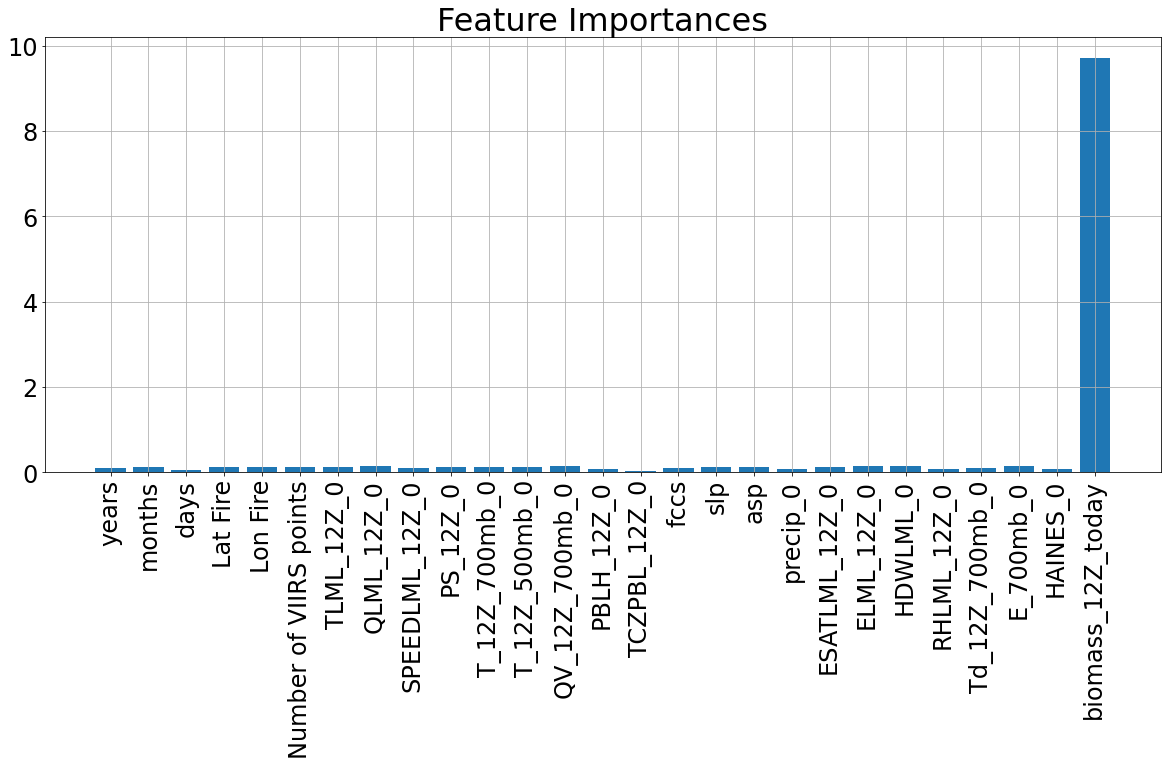

ValueError: The number of FixedLocator locations (26), usually from a call to set_ticks, does not match the number of ticklabels (27).

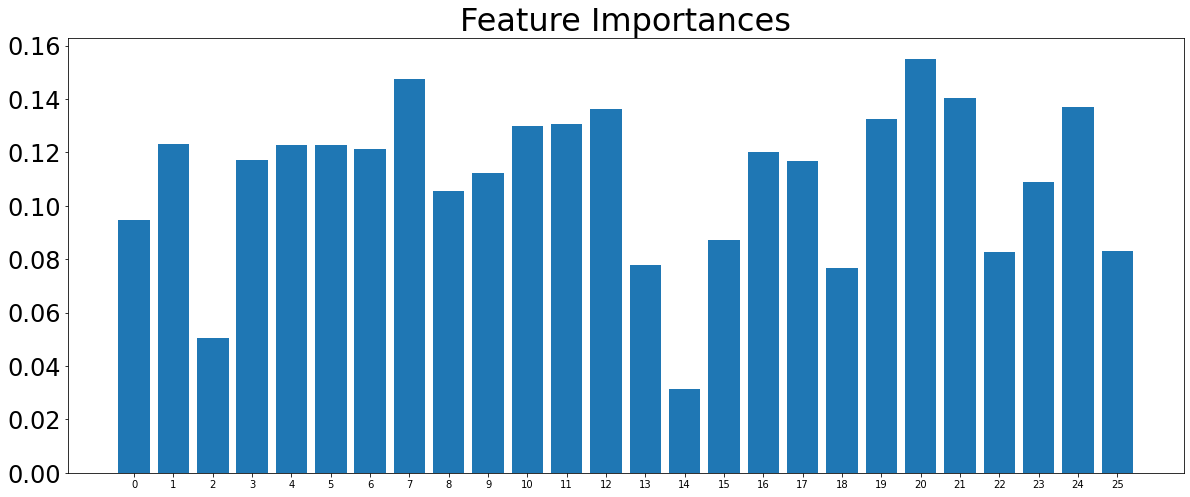

In [13]:
svr_day0 = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2)) #scaling is necessary!
svr_day0.fit(x_train_day0, np.ravel(y_train))
y_svr_day0 = svr_day0.predict(x_test_day0)
# perform permutation importance
results = permutation_importance(svr_day0, x_train_day0, y_train, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature:', feat_names[i], ', Score: %.5f' % (v))
plt.figure(figsize=(20,8))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Feature Importances', fontsize=32)
plt.yticks(fontsize=24)
plt.xticks([i for i in range(len(importance))], labels = feat_day0, fontsize=24, rotation='vertical')
plt.grid(True)
plt.show()

plt.figure(figsize=(20,8))
plt.bar([x for x in range(len(importance)-1)], importance[0:len(importance)-1])
plt.title('Feature Importances', fontsize=32)
plt.yticks(fontsize=24)
plt.xticks([i for i in range(len(importance)-1)], labels = feat_day0, fontsize=24, rotation='vertical')
plt.grid(True)
plt.show()

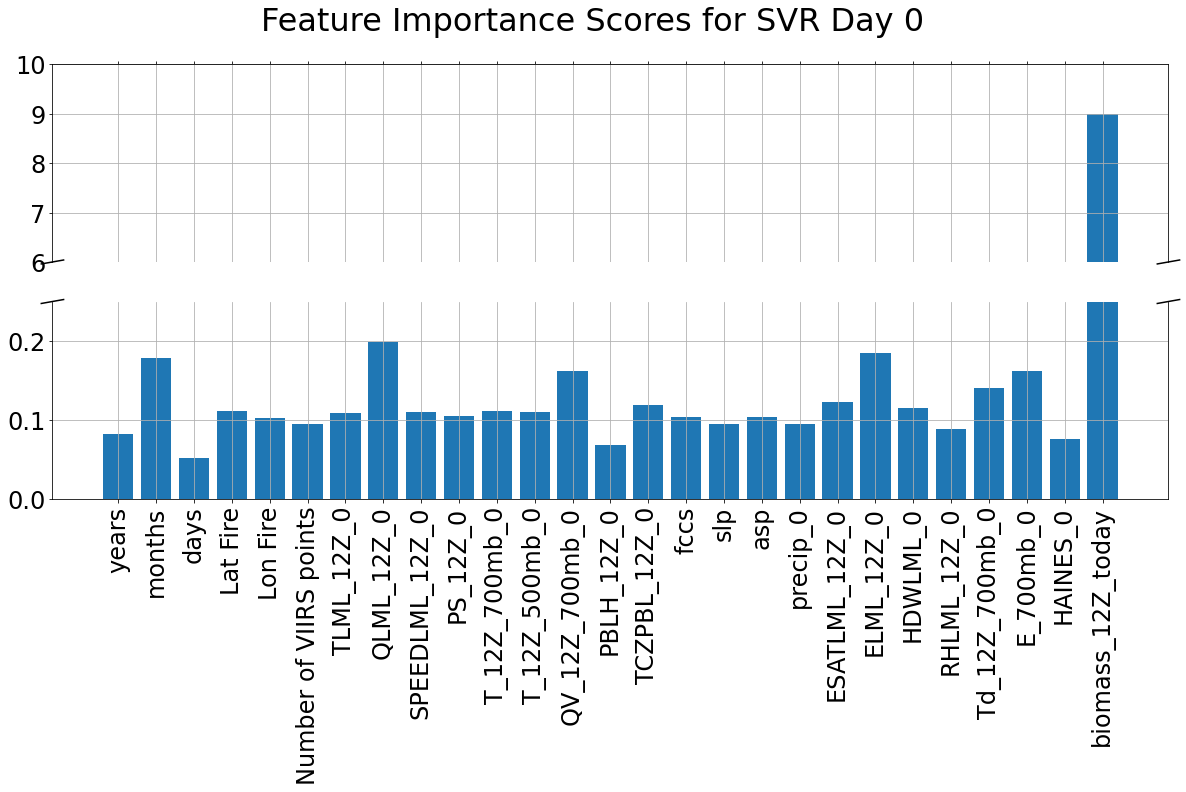

In [95]:
# for a broken axis feature importance plot
# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature:', feat_day0[i], ', Score: %.5f' % (v))
    
f, (ax, ax2) = plt.subplots(2, 1, sharex=True,figsize=(20,8))
ax.bar([x for x in range(len(importance))], importance)
ax.tick_params(axis='y', labelsize= 24) 
ax2.bar([x for x in range(len(importance))], importance)
ax2.tick_params(axis='y', labelsize= 24) 

ax.set_ylim(6, 10)  # outliers only
ax2.set_ylim(0, .25)  # most of the data

ax.grid(True)
ax2.grid(True)

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.xticks([i for i in range(len(importance))], labels = feat_day0, fontsize=24, rotation='vertical')
f.suptitle('Feature Importance Scores for SVR Day 0', fontsize=32)
plt.show()

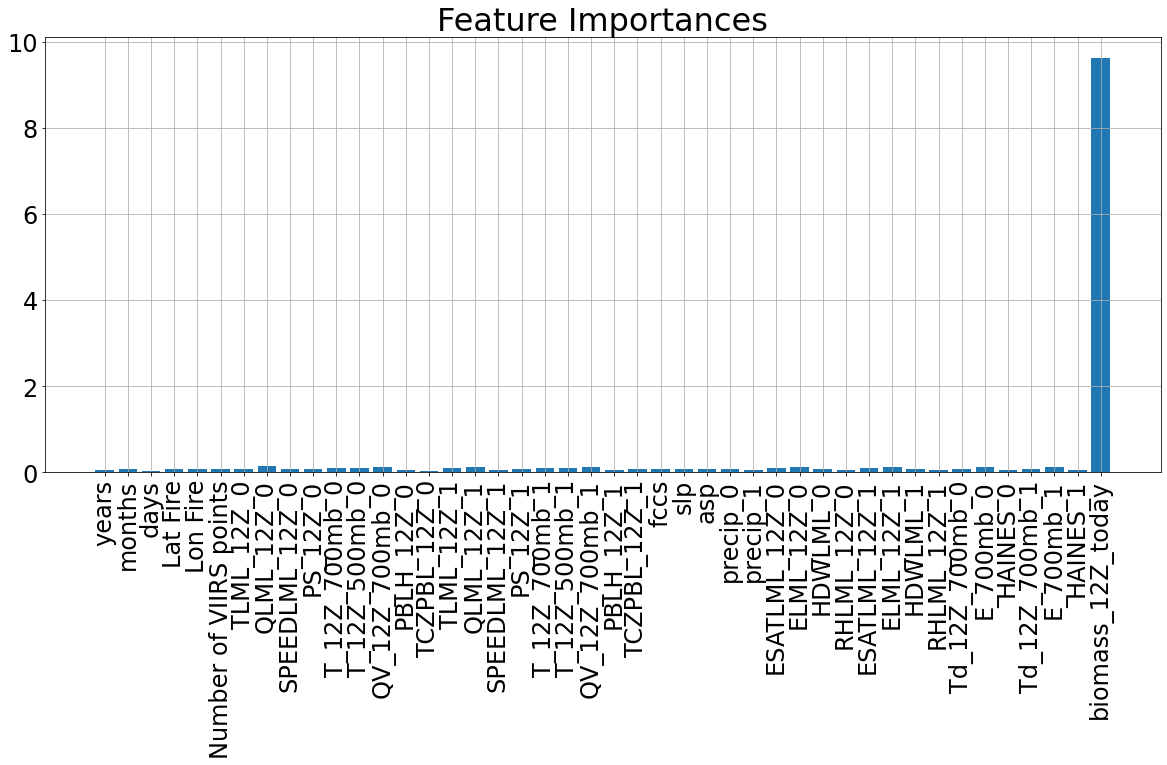

In [14]:
svr_day0and1 = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2)) #scaling is necessary!
svr_day0and1.fit(x_train_day0and1, np.ravel(y_train))
y_svr_day0and1 = svr_day0and1.predict(x_test_day0and1)
# perform permutation importance
results = permutation_importance(svr_day0and1, x_train_day0and1, y_train, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature:', feat_names[i], ', Score: %.5f' % (v))
plt.figure(figsize=(20,8))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Feature Importances', fontsize=32)
plt.yticks(fontsize=24)
plt.xticks([i for i in range(len(importance))], labels = feat_day0and1, fontsize=24, rotation='vertical')
plt.grid(True)
plt.show()

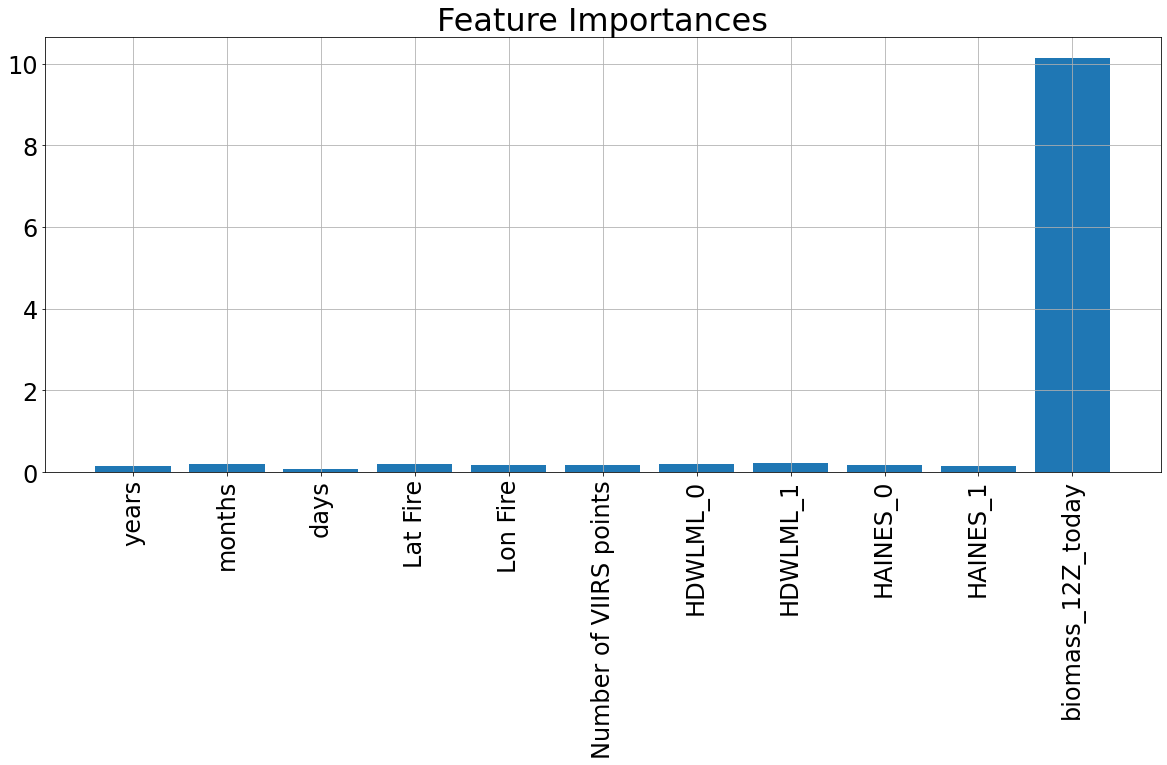

In [15]:
svr_day0and1_indices = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2)) #scaling is necessary!
svr_day0and1_indices.fit(x_train_day0and1_indices, np.ravel(y_train))
y_svr_day0and1_indices = svr_day0and1_indices.predict(x_test_day0and1_indices)
# perform permutation importance
results = permutation_importance(svr_day0and1_indices, x_train_day0and1_indices, y_train, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature:', feat_names[i], ', Score: %.5f' % (v))
plt.figure(figsize=(20,8))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Feature Importances', fontsize=32)
plt.yticks(fontsize=24)
plt.xticks([i for i in range(len(importance))], labels = feat_day0and1_indices, fontsize=24, rotation='vertical')
plt.grid(True)
plt.show()

## Evaluate the models

In [16]:
# Check the shapes
print('LR shapes are:',y_lr_day0_emiss.shape, y_lr_day0_emiss_static.shape, y_lr_day0.shape, y_lr_day0and1.shape, y_lr_day0and1_indices.shape)
print('SVR shapes are:', y_svr_day0_emiss.shape, y_svr_day0_emiss_static.shape, y_svr_day0.shape, y_svr_day0and1.shape, y_lr_day0and1_indices.shape)
print('Persistence shape is:', y_pred_persistence.shape)
print('True value shape is:', y_test.shape)

# undo the log transform and reshape
y_lr_day0_emiss_lin = 10**y_lr_day0_emiss
y_lr_day0_emiss_static_lin = 10**y_lr_day0_emiss_static
y_lr_day0_lin = 10**y_lr_day0
y_lr_day0and1_lin = 10**y_lr_day0and1
y_lr_day0and1_indices_lin = 10**y_lr_day0and1_indices

y_svr_day0_emiss_lin = 10**y_svr_day0_emiss
y_svr_day0_emiss_static_lin = 10**y_svr_day0_emiss_static
y_svr_day0_lin = 10**y_svr_day0
y_svr_day0and1_lin = 10**y_svr_day0and1
y_svr_day0and1_indices_lin = 10**y_svr_day0and1_indices

y_pred_persistence_lin = 10**y_pred_persistence.values[:,0]
y_test_lin = 10**y_test

print('LR transformed shapes are:', y_lr_day0_emiss_lin.shape, y_lr_day0_emiss_static_lin.shape, y_lr_day0_lin.shape, y_lr_day0and1_lin.shape, y_lr_day0and1_indices_lin.shape)
print('SVR transformed shapes are:', y_svr_day0_emiss_lin.shape, y_svr_day0_emiss_static_lin.shape, y_svr_day0_lin.shape, y_svr_day0and1_lin.shape, y_lr_day0and1_indices_lin.shape)
print('Persistence transformed shape is:', y_pred_persistence_lin.shape)
print('True value transformed shape is:', y_test_lin.shape)

LR shapes are: (1182,) (1182,) (1182,) (1182,) (1182,)
SVR shapes are: (1182,) (1182,) (1182,) (1182,) (1182,)
Persistence shape is: (1182, 1)
True value shape is: (1182,)
LR transformed shapes are: (1182,) (1182,) (1182,) (1182,) (1182,)
SVR transformed shapes are: (1182,) (1182,) (1182,) (1182,) (1182,)
Persistence transformed shape is: (1182,)
True value transformed shape is: (1182,)


In [17]:
print('lr_day0_emiss: RMSE=', RMSE(y_lr_day0_emiss_lin, y_test_lin), 'MAD=', MAD(y_lr_day0_emiss_lin, y_test_lin), 'R2=',np.corrcoef(y_lr_day0_emiss_lin, y_test_lin)[0,1] )
print('lr_day0_emiss_static: RMSE=', RMSE(y_lr_day0_emiss_static_lin, y_test_lin), 'MAD=', MAD(y_lr_day0_emiss_static_lin, y_test_lin), 'R2=',np.corrcoef(y_lr_day0_emiss_static_lin, y_test_lin)[0,1] )
print('lr_day0: RMSE=', RMSE(y_lr_day0_lin, y_test_lin), 'MAD=', MAD(y_lr_day0_lin, y_test_lin), 'R2=',np.corrcoef(y_lr_day0_lin, y_test_lin)[0,1] )
print('lr_day0and1: RMSE=', RMSE(y_lr_day0and1_lin, y_test_lin), 'MAD=', MAD(y_lr_day0and1_lin, y_test_lin), 'R2=',np.corrcoef(y_lr_day0and1_lin, y_test_lin)[0,1] )
print('lr_day0and1_indices: RMSE=', RMSE(y_lr_day0and1_indices_lin, y_test_lin), 'MAD=', MAD(y_lr_day0and1_indices_lin, y_test_lin), 'R2=',np.corrcoef(y_lr_day0and1_indices_lin, y_test_lin)[0,1] )

print('svr_day0_emiss: RMSE=', RMSE(y_svr_day0_emiss_lin, y_test_lin), 'MAD=', MAD(y_svr_day0_emiss_lin, y_test_lin), 'R2=',np.corrcoef(y_svr_day0_emiss_lin, y_test_lin)[0,1] )
print('svr_day0_emiss_static: RMSE=', RMSE(y_svr_day0_emiss_static_lin, y_test_lin), 'MAD=', MAD(y_svr_day0_emiss_static_lin, y_test_lin), 'R2=',np.corrcoef(y_svr_day0_emiss_static_lin, y_test_lin)[0,1] )
print('svr_day0: RMSE=', RMSE(y_svr_day0_lin, y_test_lin), 'MAD=', MAD(y_svr_day0_lin, y_test_lin), 'R2=',np.corrcoef(y_svr_day0_lin, y_test_lin)[0,1] )
print('svr_day0and1: RMSE=', RMSE(y_svr_day0and1_lin, y_test_lin), 'MAD=', MAD(y_svr_day0and1_lin, y_test_lin), 'R2=',np.corrcoef(y_svr_day0and1_lin, y_test_lin)[0,1] )
print('svr_day0and1_indices: RMSE=', RMSE(y_svr_day0and1_indices_lin, y_test_lin), 'MAD=', MAD(y_svr_day0and1_indices_lin, y_test_lin), 'R2=',np.corrcoef(y_svr_day0and1_indices_lin, y_test_lin)[0,1] )

print('persistence: RMSE=', RMSE(y_pred_persistence_lin, y_test_lin), 'MAD=', MAD(y_pred_persistence_lin, y_test_lin), 'R2=',np.corrcoef(y_pred_persistence_lin, y_test_lin)[0,1] )

NameError: name 'RMSE' is not defined

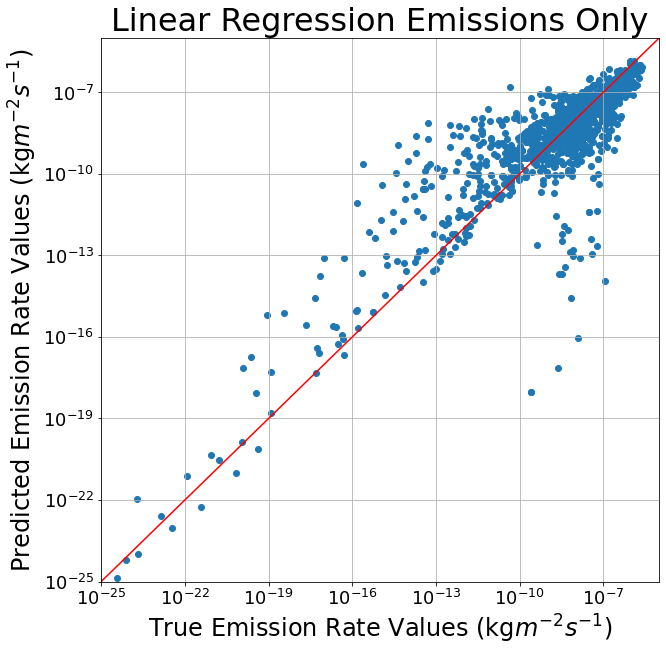

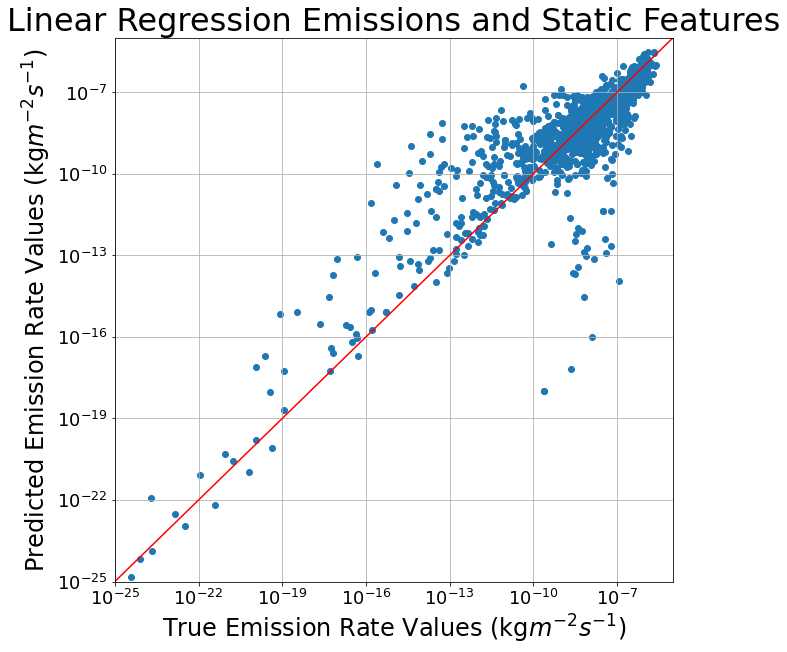

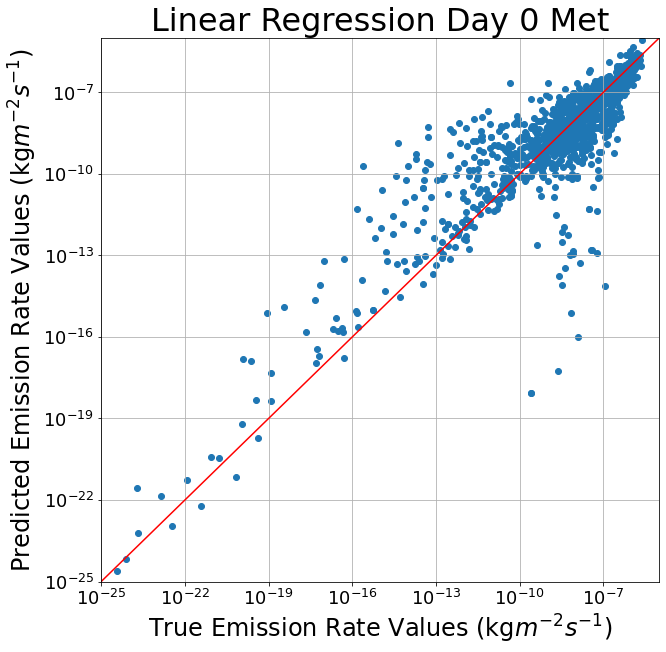

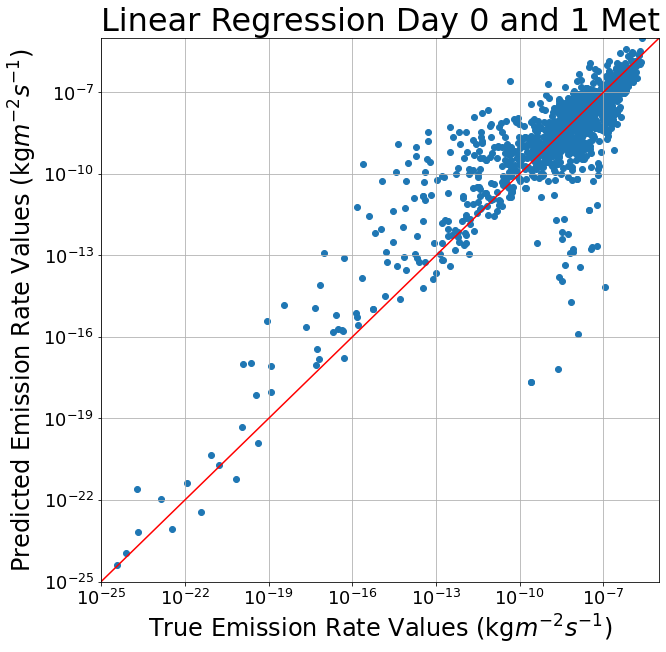

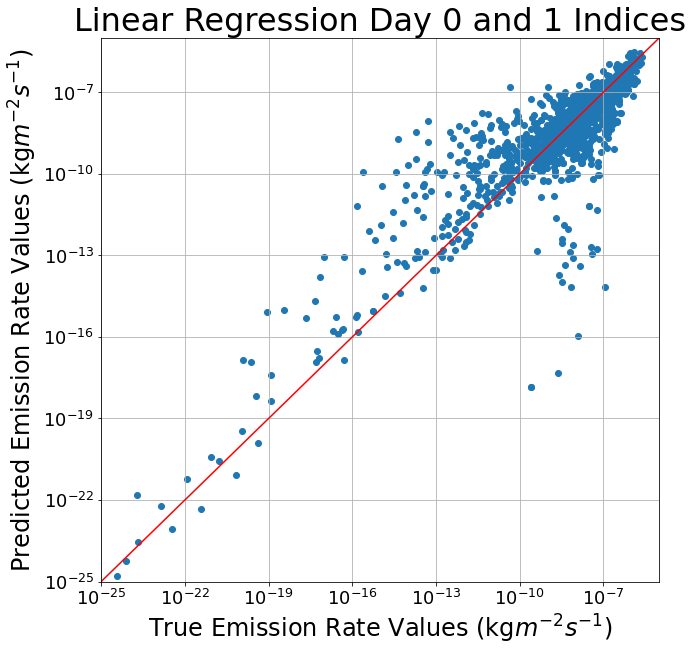

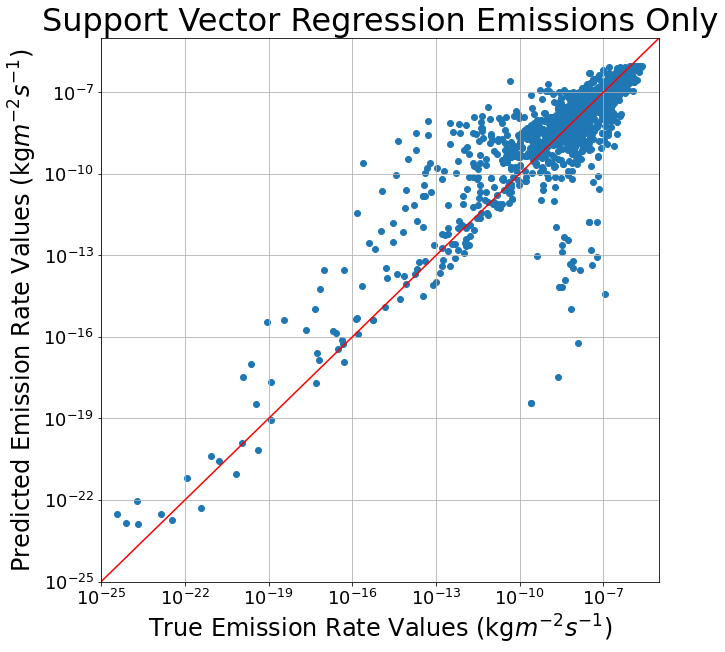

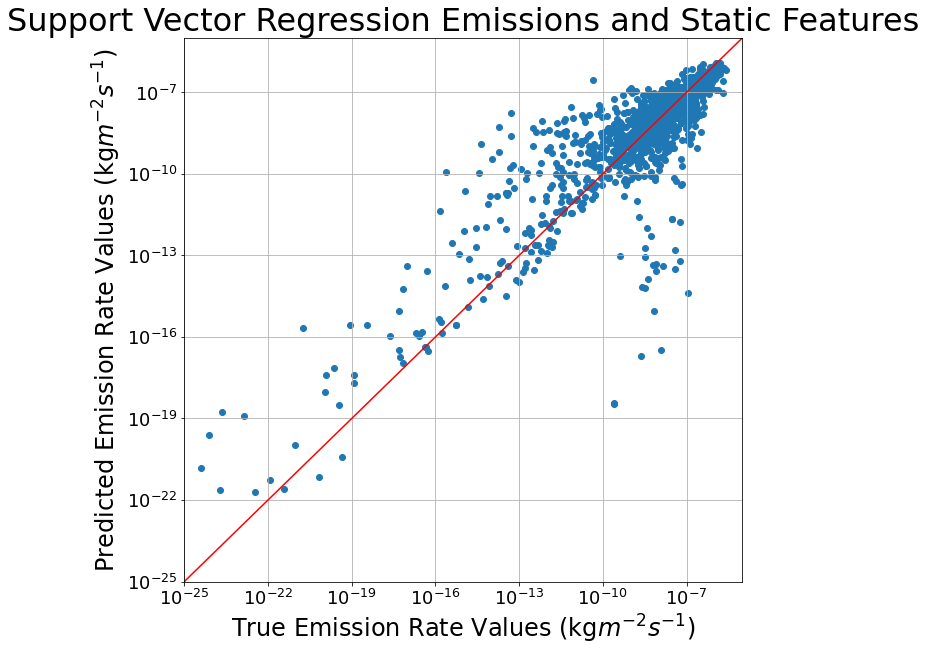

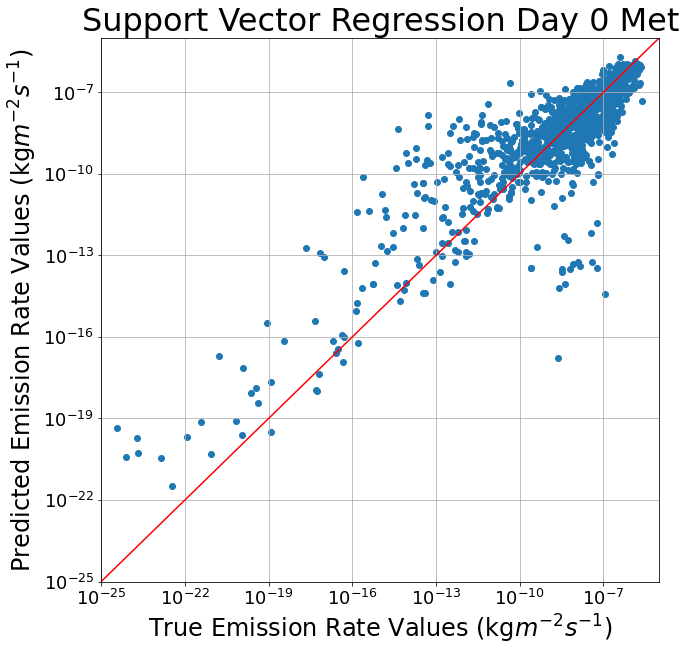

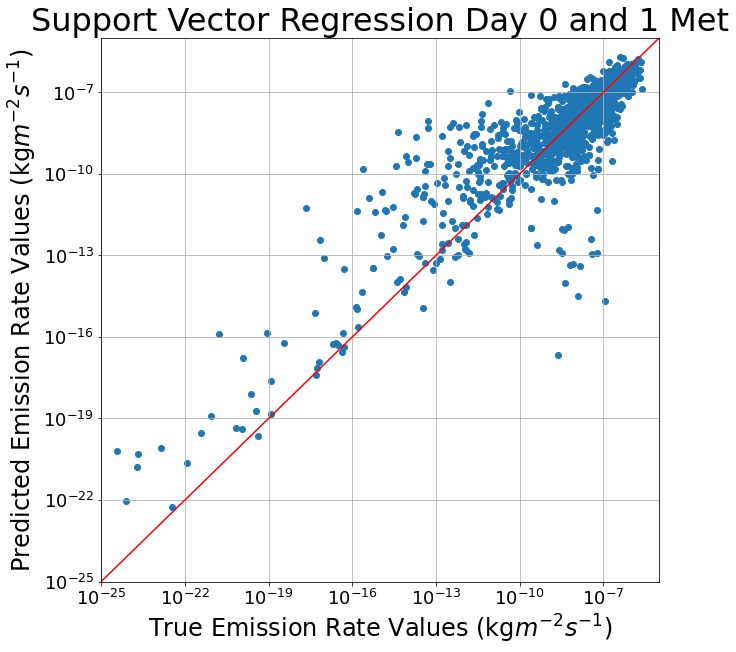

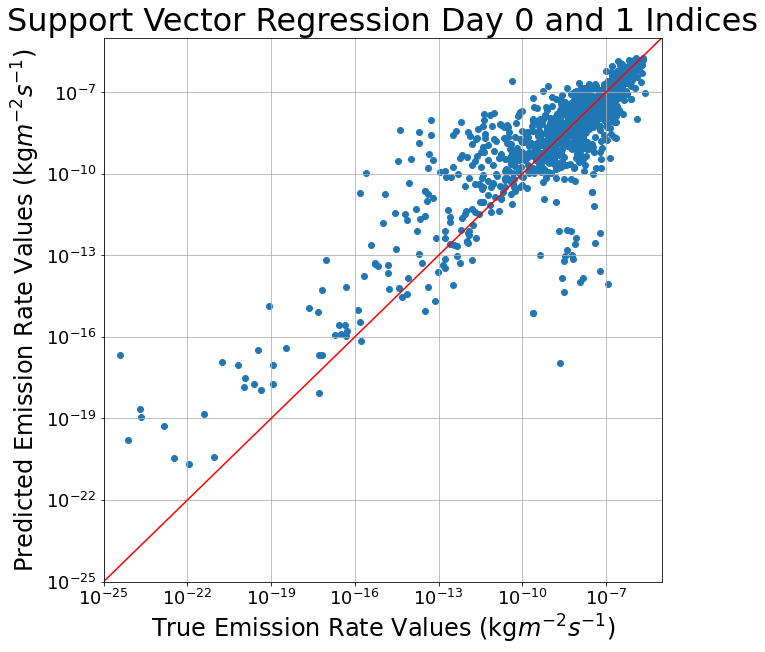

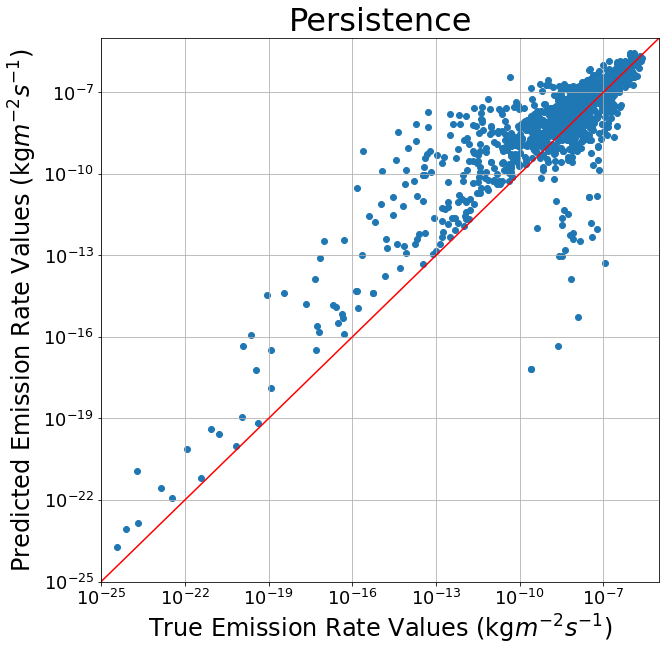

In [22]:
low = 1e-25
high = 1e-5
plot_log(y_test_lin, y_lr_day0_emiss_lin, 'Linear Regression Emissions Only', low, high)
plot_log(y_test_lin, y_lr_day0_emiss_static_lin, 'Linear Regression Emissions and Static Features', low, high)
plot_log(y_test_lin, y_lr_day0_lin, 'Linear Regression Day 0 Met', low, high)
plot_log(y_test_lin, y_lr_day0and1_lin, 'Linear Regression Day 0 and 1 Met', low, high)
plot_log(y_test_lin, y_lr_day0and1_indices_lin, 'Linear Regression Day 0 and 1 Indices', low, high)

plot_log(y_test_lin, y_svr_day0_emiss_lin, 'Support Vector Regression Emissions Only', low, high)
plot_log(y_test_lin, y_svr_day0_emiss_static_lin, 'Support Vector Regression Emissions and Static Features', low, high)
plot_log(y_test_lin, y_svr_day0_lin, 'Support Vector Regression Day 0 Met', low, high)
plot_log(y_test_lin, y_svr_day0and1_lin, 'Support Vector Regression Day 0 and 1 Met', low, high)
plot_log(y_test_lin, y_svr_day0and1_indices_lin, 'Support Vector Regression Day 0 and 1 Indices', low, high)

plot_log(y_test_lin, y_pred_persistence_lin, 'Persistence', low, high)

In [21]:
def plot_log(y_test, y_pred, model_name, low, high):
    plt.figure(figsize=(10,10))
    plt.scatter(y_test, y_pred)
    plt.plot(np.linspace(low, high),np.linspace(low,high), c='r')
    plt.title(model_name,  fontsize=32)
    plt.xlabel('True Emission Rate Values (kg$m^{-2}$$s^{-1}$)', fontsize=24)
    plt.ylabel('Predicted Emission Rate Values (kg$m^{-2}$$s^{-1}$)', fontsize=24)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    plt.xlim([low, high])
    plt.ylim([low, high])
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

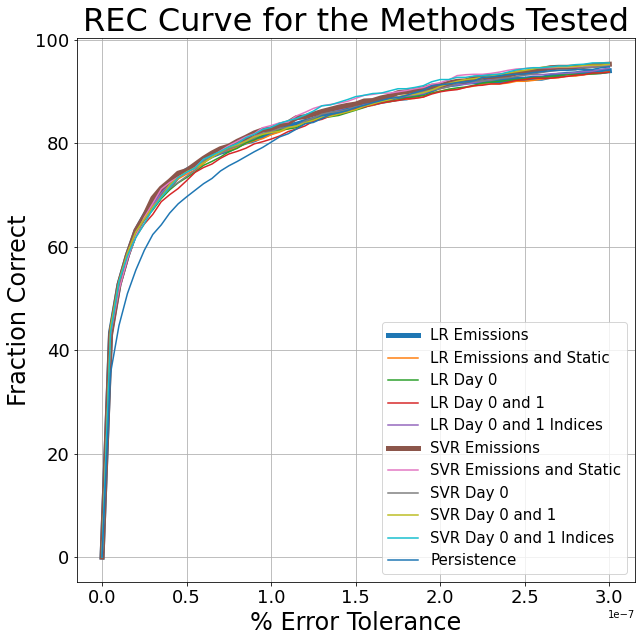

In [39]:
def REC(y_pred, y_test):
    #percent_error = np.abs((y_pred-y_test)/y_test)*100
    #thresholds = np.linspace(0,150, 31) #5% increments

    percent_error = np.abs(y_pred-y_test)
    thresholds = np.linspace(0, 0.3e-6, 61) #5% increments
    acc = np.zeros(thresholds.shape)
    for ii in range(len(thresholds)):
        n_correct = len(percent_error[percent_error<=thresholds[ii]])
        acc[ii] = n_correct*100/len(y_test)
    return thresholds, acc

# calculate REC curves fror the 7 models
t_lr_day0_emiss, a_lr_day0_emiss = REC(y_lr_day0_emiss_lin, y_test_lin)
t_lr_day0_emiss_static, a_lr_day0_emiss_static = REC(y_lr_day0_emiss_static_lin, y_test_lin)
t_lr_day0, a_lr_day0 = REC(y_lr_day0_lin, y_test_lin)
t_lr_day0and1, a_lr_day0and1 = REC(y_lr_day0and1_lin, y_test_lin)
t_lr_day0and1_indices, a_lr_day0and1_indices = REC(y_lr_day0and1_indices_lin, y_test_lin)

t_svr_day0_emiss, a_svr_day0_emiss = REC(y_svr_day0_emiss_lin, y_test_lin)
t_svr_day0_emiss_static, a_svr_day0_emiss_static = REC(y_svr_day0_emiss_static_lin, y_test_lin)
t_svr_day0, a_svr_day0 = REC(y_svr_day0_lin, y_test_lin)
t_svr_day0and1, a_svr_day0and1 = REC(y_svr_day0and1_lin, y_test_lin)
t_svr_day0and1_indices, a_svr_day0and1_indices = REC(y_svr_day0and1_indices_lin, y_test_lin)

thresholds_persistence, accuracy_persistence = REC(y_pred_persistence_lin, y_test_lin)

plt.figure(figsize=(10,10))
plt.plot(t_lr_day0_emiss, a_lr_day0_emiss, linewidth=5)
plt.plot(t_lr_day0_emiss_static, a_lr_day0_emiss_static)
plt.plot(t_lr_day0, a_lr_day0)
plt.plot(t_lr_day0and1, a_lr_day0and1)
plt.plot(t_lr_day0and1_indices, a_lr_day0and1_indices)

plt.plot(t_svr_day0_emiss, a_svr_day0_emiss, linewidth=5)
plt.plot(t_svr_day0_emiss_static, a_svr_day0_emiss_static)
plt.plot(t_svr_day0, a_svr_day0)
plt.plot(t_svr_day0and1, a_svr_day0and1)
plt.plot(t_svr_day0and1_indices, a_svr_day0and1_indices)
plt.plot(thresholds_persistence, accuracy_persistence)

plt.legend(['LR Emissions', 'LR Emissions and Static','LR Day 0', 'LR Day 0 and 1', 'LR Day 0 and 1 Indices', 'SVR Emissions','SVR Emissions and Static','SVR Day 0', 'SVR Day 0 and 1', 'SVR Day 0 and 1 Indices', 'Persistence'],fontsize=15)
plt.title('REC Curve for the Methods Tested', fontsize=32)
plt.ylabel('Fraction Correct', fontsize=24)
plt.xlabel('% Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

In [18]:
def RMSE(y_pred,y_test):
    return np.sqrt(np.mean(((y_pred)-(y_test))**2))

def MAD(y_pred,y_test):
    return np.mean(np.abs(y_pred-y_test))

# rec curve approaches 100% and persistence at large values. Elbow because points gets scarce after 100% error. Suggests ML improves the large error of persistence, although all features are the same

2.5120981387478847e-05
2.49906937394247e-05
2.5e-05
2.489763113367174e-05
2.5199661590524532e-05
2.4689086294416244e-05


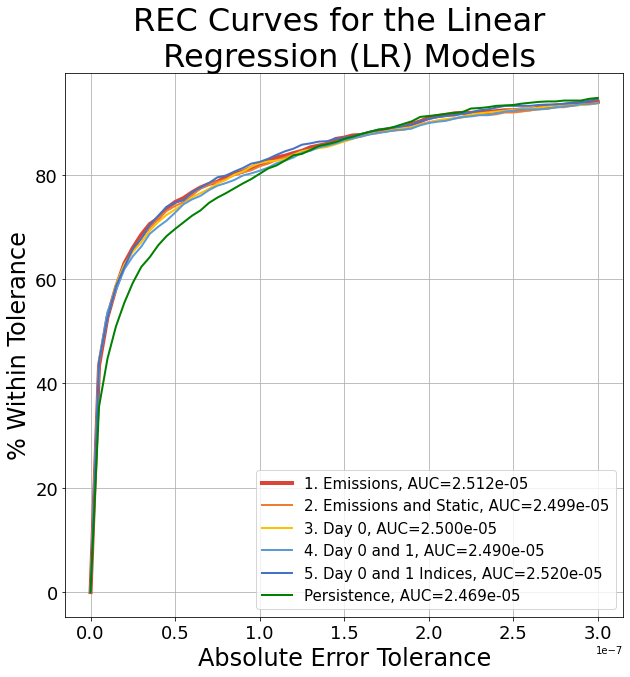

In [91]:
plt.figure(figsize=(10,10))
plt.plot(t_lr_day0_emiss, a_lr_day0_emiss, c = '#D94638', linewidth = 4)
plt.plot(t_lr_day0_emiss_static, a_lr_day0_emiss_static, c='#ED7D31', linewidth=2)
plt.plot(t_lr_day0, a_lr_day0, c = '#FFC000', linewidth=2)
plt.plot(t_lr_day0and1, a_lr_day0and1, c='#5B9BD5', linewidth=2)
plt.plot(t_lr_day0and1_indices, a_lr_day0and1_indices, c='#4472C4', linewidth=2 )


plt.plot(thresholds_persistence, accuracy_persistence, c = 'g', linewidth=2)

#get the AUCs
area_lr_day0_emiss = auc(t_lr_day0_emiss, a_lr_day0_emiss)
area_lr_day0_emiss_static =auc(t_lr_day0_emiss_static, a_lr_day0_emiss_static)
area_lr_day0 =auc(t_lr_day0, a_lr_day0)
area_lr_day0and1 =auc(t_lr_day0and1, a_lr_day0and1)
area_lr_day0and1_indices =auc(t_lr_day0and1_indices, a_lr_day0and1_indices)
area_persistence =auc(thresholds_persistence, accuracy_persistence)

plt.legend(['1. Emissions, AUC='+"{:.3e}".format(area_lr_day0_emiss),
            '2. Emissions and Static, AUC='+"{:.3e}".format(area_lr_day0_emiss_static), 
            '3. Day 0, AUC='+"{:.3e}".format(area_lr_day0), 
            '4. Day 0 and 1, AUC='+"{:.3e}".format(area_lr_day0and1), 
            '5. Day 0 and 1 Indices, AUC='+"{:.3e}".format(area_lr_day0and1_indices),  
            'Persistence, AUC='+"{:.3e}".format(area_persistence)],fontsize=15)

plt.title('REC Curves for the Linear \n Regression (LR) Models', fontsize=32)
plt.ylabel('% Within Tolerance', fontsize=24)
plt.xlabel('Absolute Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.grid(True)
plt.show()

2.5360829103214887e-05
2.5438663282571912e-05
2.51577834179357e-05
2.522842639593908e-05
2.5433587140439934e-05
2.4689086294416244e-05


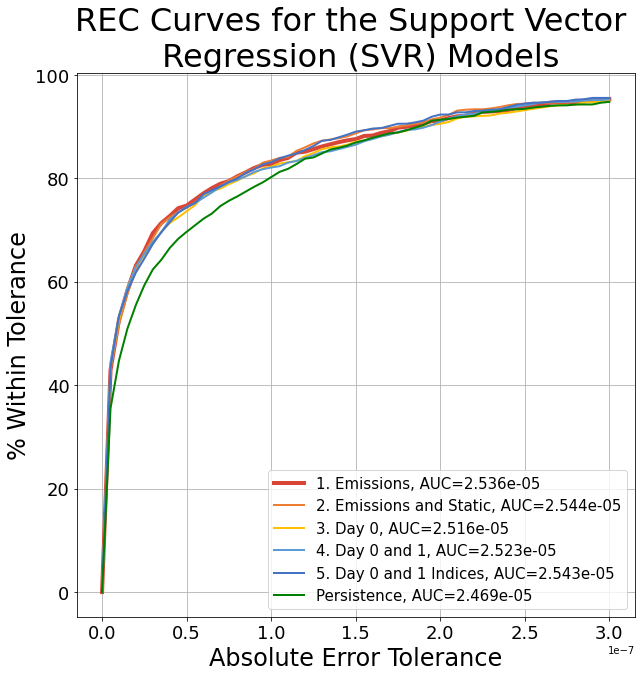

In [90]:
plt.figure(figsize=(10,10))
plt.plot(t_svr_day0_emiss, a_svr_day0_emiss, c = '#D94638', linewidth = 4)
plt.plot(t_svr_day0_emiss_static, a_svr_day0_emiss_static, c='#ED7D31', linewidth=2)
plt.plot(t_svr_day0, a_svr_day0, c = '#FFC000', linewidth=2)
plt.plot(t_svr_day0and1, a_svr_day0and1, c='#5B9BD5', linewidth=2)
plt.plot(t_svr_day0and1_indices, a_svr_day0and1_indices, c='#4472C4', linewidth=2 )
plt.plot(thresholds_persistence, accuracy_persistence, c = 'g', linewidth=2)

#get the AUCs
area_svr_day0_emiss = auc(t_svr_day0_emiss, a_svr_day0_emiss)
area_svr_day0_emiss_static =auc(t_svr_day0_emiss_static, a_svr_day0_emiss_static)
area_svr_day0 =auc(t_svr_day0, a_svr_day0)
area_svr_day0and1 =auc(t_svr_day0and1, a_svr_day0and1)
area_svr_day0and1_indices =auc(t_svr_day0and1_indices, a_svr_day0and1_indices)
area_persistence =auc(thresholds_persistence, accuracy_persistence)

plt.legend(['1. Emissions, AUC='+"{:.3e}".format(area_svr_day0_emiss),
            '2. Emissions and Static, AUC='+"{:.3e}".format(area_svr_day0_emiss_static), 
            '3. Day 0, AUC='+"{:.3e}".format(area_svr_day0), 
            '4. Day 0 and 1, AUC='+"{:.3e}".format(area_svr_day0and1), 
            '5. Day 0 and 1 Indices, AUC='+"{:.3e}".format(area_svr_day0and1_indices),  
            'Persistence, AUC='+"{:.3e}".format(area_persistence)],fontsize=15)
plt.title('REC Curves for the Support Vector \n Regression (SVR) Models', fontsize=32)
plt.ylabel('% Within Tolerance', fontsize=24)
plt.xlabel('Absolute Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.grid(True)
plt.show()

In [70]:
def auc(thresh, acc):
    delta = thresh[1:len(thresh)]-thresh[0:len(thresh)-1]
    #print(delta[0])
    #area = np.sum(delta*thresh[0:len(thresh)-1]))#left endpoint rectangle
    area = np.sum(delta*acc[1:len(thresh)])#right endpoint rectangle
    print(area)
    return area 


In [84]:
"{:.2e}".format(area_svr_day0_emiss)

'2.54e-05'